# Test 5 & 6: Cholesky for increasing problem size

In [4]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils
import math

import warnings

warnings.filterwarnings("ignore")

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 7})
mpl.rcParams.update({"grid.linewidth": 0.5})
mpl.rcParams.update({"legend.fontsize": 9})
mpl.rcParams.update({"lines.markersize": 6})


def figsize(x, y, y_log_min=1, y_log_max=1):
    """
    Set figsize based on same bounding box to achive shared axes
    """
    x_const = 0.5847574256049264
    y_const = 0.43668402777777837
    return (
        x + x_const,
        (y + math.log10(y_log_max) - math.log10(y_log_min)) * 0.4 + y_const,
    )

# bbox = ax.get_position()
# fig_width, fig_height = fig.get_size_inches()
# print((1 - (bbox.x1 - bbox.x0)) * fig_width, (1 - (bbox.y1 - bbox.y0)) * fig_height)

In [5]:
# load data

apex_dir_cholesky = "./data/5/"
apex_dir_steps = "./data/6/"
subdirs = [
    "apex-cpu/",
    "apex-gpu/"
]

names_cholesky = [
    "cholesky"
]

names_steps = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]

file_headers_cpu = ["n_cores", "n_train", "n_tiles", "n_reg", "n_loops"]

file_headers_gpu = [
    "n_cores",
    "n_train",
    "n_tiles",
    "n_reg",
    "n_streams",
    "n_loops"
]

def apex_files_to_df(dir, names, file_headers):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by=["n_train", "n_tiles"])
    return df_combined

df_cholesky = []
df_steps = []
df_cholesky.append(
    apex_files_to_df(apex_dir_cholesky + subdirs[0], names_cholesky, file_headers_cpu)
)
df_cholesky.append(
    apex_files_to_df(apex_dir_cholesky + subdirs[1], names_cholesky, file_headers_gpu)
)
df_steps.append(apex_files_to_df(apex_dir_steps + subdirs[0], names_steps, file_headers_cpu))
df_steps.append(apex_files_to_df(apex_dir_steps + subdirs[1], names_steps, file_headers_gpu))

23      0.000329
21      0.000168
1       0.000190
4       0.000184
18      0.000226
8       0.000410
20      0.000940
16      0.003039
15      0.010955
19      0.042104
17      0.165027
12      0.673238
10      2.380761
9      10.544588
6      53.511285
5     327.434572
Name: mean, dtype: float64
11     0.185392
13     0.186349
25     0.185928
2      0.200170
14     0.211688
26     0.213270
0      0.244493
22     0.328982
7      1.243891
24     7.343637
3     47.437837
Name: mean, dtype: float64
6     0.001158
5     0.000794
7     0.000835
14    0.000804
15    0.000798
21    0.000844
26    0.000861
4     0.000996
24    0.001124
17    0.001682
18    0.004404
13    0.007454
11    0.020131
2     0.081240
10    0.354455
19    1.903835
Name: mean, dtype: float64
20     0.111279
22     0.087931
23     0.096708
0      0.084206
1      0.085444
25     0.084635
3      0.087218
8      0.095514
27     0.133887
12     0.419208
9      1.714120
16    13.754214
Name: mean, dtype: float64


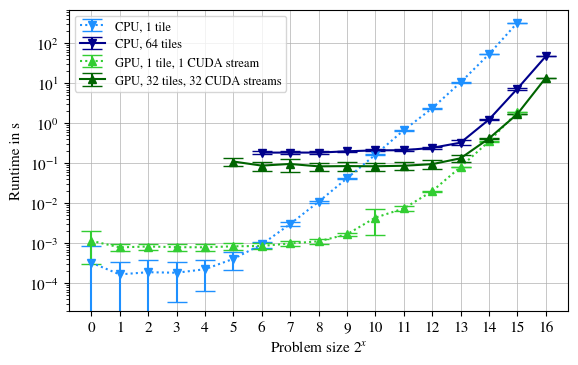

In [ ]:
# plot for cholesky

n_train = 32768

fig, ax = plt.subplots(figsize=figsize(5, 7, 2, 7))

plt.xlabel('Problem size $2^x$')
plt.ylabel('Runtime in s')
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale('log', base=2)
plt.yscale("log", base=10)
# plt.xlim(100, 83000)
plt.ylim(2*10**(-5), 7*10**2)

xticks = df_cholesky[1]['n_train'].unique()
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

ls = [(0, (1, 1.5)), "-"]
colors = ["dodgerblue", "darkblue"]
df_name_target = df_cholesky[0]
for n_tiles, l, c in zip(df_name_target["n_tiles"].unique(), ls, colors):
    df_name_target_n_tiles = df_name_target[df_name_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_name_target_n_tiles, 0.95)
    tile = "tile" if n_tiles == 1 else "tiles"
    plt.errorbar(
        df_name_target_n_tiles["n_train"],
        df_name_target_n_tiles["mean"] / 10**9,
        yerr=err / 10**9,
        label="CPU, " + str(n_tiles) + f" {tile}",
        linestyle=l,
        color=c,
        marker="v",
        )

ls = [(0, (1, 1.5)), "-"]
colors = ["limegreen", "darkgreen"]
labels = ["GPU, 1 tile, 1 CUDA stream", "GPU, 32 tiles, 32 CUDA streams"]
df_name_target = df_cholesky[1]
for n_tiles, l, c, label in zip(df_name_target["n_tiles"].unique(), ls, colors, labels):
    df_name_target_n_tiles = df_name_target[df_name_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_name_target_n_tiles, 0.95)
    tile = "tile" if n_tiles == 1 else "tiles"
    plt.errorbar(
        df_name_target_n_tiles["n_train"],
        df_name_target_n_tiles["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
        linestyle=l,
        color=c,
        marker="^",
    )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-cpu-gpu.pdf")